#Installing transformers and necessary libraries

In [ ]:
!pip install --upgrade transformers


In [ ]:
!pip install transformers datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and

In [ ]:
from datasets import load_dataset, Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import DataCollatorForSeq2Seq
import evaluate
import numpy as np
import pandas as pd

#Load dataset

In [ ]:
df = pd.read_csv("/content/dataset (1).csv")  # Replace with your file path
dataset = Dataset.from_pandas(df[['Full Article', 'Summary']])
df = df[["Full Article", "Summary"]].dropna()
df["Full Article"] = df["Full Article"].astype(str)
df["Summary"] = df["Summary"].astype(str)

In [ ]:

dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]


#Load tokenizer and model

In [ ]:
model_checkpoint = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_checkpoint)
model = BartForConditionalGeneration.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

#Data Preprocessing

In [ ]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["Full Article"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True
    )

    labels = tokenizer(
        examples["Summary"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True, remove_columns=eval_dataset.column_names)

#Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)



Map:   0%|          | 0/902 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

In [ ]:
!pip install rouge_score
!pip install bleu_score
# Define metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c964d876b7ce8def78f926146ac04c680c331ce306f1243960eed2606947da08
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
ERROR: Could not find a version that satisfies the requirement bleu_score (from versions: none)
ERROR: No matching distribution found for bleu_score


In [ ]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    bleu_result = bleu.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])

    result = {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bleu": bleu_result["bleu"]
    }
    return {k: round(v, 4) for k, v in result.items()}

#Training Arguements

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-summary",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,  # runs eval every 200 steps
    save_total_limit=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=100,
    fp16=False
)


In [ ]:
# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



<ipython-input-14-edd56e9117c2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sreyaiitpatna (sreyaiitpatna-indian-institute-of-technology-patna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,3.022100
100,1.569600
150,1.127100
200,0.907500
250,0.911200
300,0.918500
350,0.844900
400,0.909200
450,0.799300
500,0.579800


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=1353, training_loss=0.7252042054777575, metrics={'train_runtime': 2448.9446, 'train_samples_per_second': 1.105, 'train_steps_per_second': 0.552, 'total_flos': 5864185053315072.0, 'train_loss': 0.7252042054777575, 'epoch': 3.0})

In [ ]:
model.save_pretrained("./bart-summary-model")
tokenizer.save_pretrained("./bart-summary-model")


('./bart-summary-model/tokenizer_config.json',
 './bart-summary-model/special_tokens_map.json',
 './bart-summary-model/vocab.json',
 './bart-summary-model/merges.txt',
 './bart-summary-model/added_tokens.json')

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

model = BartForConditionalGeneration.from_pretrained("./bart-summary-model")
tokenizer = BartTokenizer.from_pretrained("./bart-summary-model")

/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [ ]:
import random
import torch

# Pick a random article
random_idx = random.randint(0, len(eval_dataset) - 1)
article = eval_dataset[random_idx]["Full Article"]

# Tokenize input
inputs = tokenizer(article, return_tensors="pt", truncation=True, padding="max_length", max_length=1024)

# Generate summary
summary_ids = model.generate(
    inputs["input_ids"].to(model.device),
    attention_mask=inputs["attention_mask"].to(model.device),
    max_length=128,
    num_beams=4,
    early_stopping=True
)

# Decode summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("📰 Article:")
print(article)
print("\n📋 Generated Summary:")
print(summary)

# Optional: Ground truth summary
if "summary" in eval_dataset.column_names:
    print("\n✅ Actual Summary:")
    print(eval_dataset[random_idx]["summary"])



📰 Article:
The Digital Mahakumbh Mela is a unique blend of advanced technology and spiritual traditions, attracting millions of Hindu pilgrims and spiritual seekers. This year, the Indian government and local authorities have introduced digital solutions, artificial intelligence (AI), and real-time monitoring systems to manage massive crowds, enhance security, and provide better connectivity during the Mahakumbh Mela in Prayagraj.
Key features of the Digital Mahakumbh Mela include:
1. AI-powered security measures, such as facial recognition cameras, AI-driven analytics for crowd management, and anti-drone systems.
2. Mobile apps and QR-enabled services, like an AI chatbot, multilingual mobile apps, and digital donations.
3. Innovative health and safety technologies, such as underwater drones and AI-driven healthcare services.
These technological advancements aim to ensure a safer, more convenient, and seamless experience for the millions of attendees at the Mahakumbh Mela.

📋 Generated

In [ ]:
!pip install evaluate


In [ ]:
import torch
from tqdm import tqdm
import evaluate

# Load metrics
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

# Storage for predictions and references
preds = []
refs = []

# Generate summaries
for example in tqdm(eval_dataset):
    article = example["Full Article"]
    reference = example["Summary"]

    inputs = tokenizer(article, return_tensors="pt", truncation=True, padding="max_length", max_length=1024).to(model.device)

    summary_ids = model.generate(
        **inputs,
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    preds.append(generated_summary)
    refs.append(reference)

# ROUGE expects list of predictions and references
rouge_result = rouge_metric.compute(predictions=preds, references=refs)




100%|██████████| 101/101 [57:39<00:00, 34.25s/it]


In [ ]:
bleu_result = bleu_metric.compute(
    predictions=preds,             # list of strings
    references=refs                # list of strings
)

import evaluate
!pip install bert_score

# Load metrics
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

# Compute METEOR
meteor_result = meteor.compute(predictions=preds, references=refs)

# Compute BERTScore
bertscore_result = bertscore.compute(predictions=preds, references=refs, lang="en")

# Print all evaluation metrics
print("📊 Evaluation Metrics:")
print(f"ROUGE-1: {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
print(f"BLEU:    {bleu_result['bleu']:.4f}")
print(f"METEOR:  {meteor_result['meteor']:.4f}")
print(f"BERTScore Precision: {sum(bertscore_result['precision']) / len(bertscore_result['precision']):.4f}")
print(f"BERTScore Recall:    {sum(bertscore_result['recall']) / len(bertscore_result['recall']):.4f}")
print(f"BERTScore F1:        {sum(bertscore_result['f1']) / len(bertscore_result['f1']):.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Evaluation Metrics:
ROUGE-1: 0.0475
ROUGE-2: 0.0260
ROUGE-L: 0.0321
BLEU:    0.0000
METEOR:  0.0390
BERTScore Precision: 0.0813
BERTScore Recall:    0.0801
BERTScore F1:        0.0807


In [ ]:
import pandas as pd

# Create a DataFrame from the results
df_results = pd.DataFrame({
    "Article": [example["Full Article"] for example in eval_dataset],
    "Reference Summary": refs,
    "Generated Summary": preds
})

# Save to CSV
df_results.to_csv("bart_summary_predictions.csv", index=False)

print("✅ Summaries saved to 'bart_summary_predictions.csv'")


✅ Summaries saved to 'bart_summary_predictions.csv'


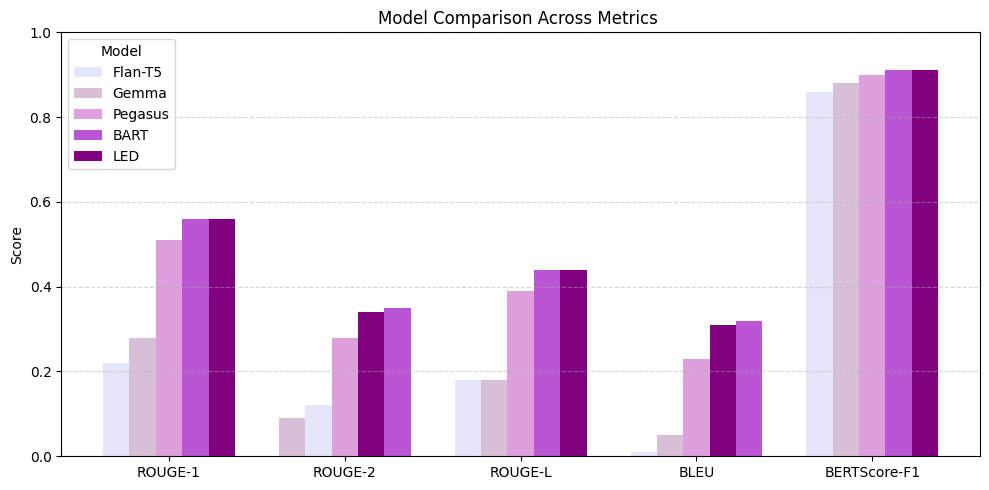

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ["Pegasus", "Flan-T5", "Gemma", "BART", "LED"]
scores = {
    "ROUGE-1":     [0.51, 0.22, 0.28, 0.56, 0.56],
    "ROUGE-2":     [0.28, 0.12, 0.09, 0.35, 0.34],
    "ROUGE-L":     [0.39, 0.18, 0.18, 0.44, 0.44],
    "BLEU":        [0.23, 0.01, 0.05, 0.32, 0.31],
    "BERTScore-F1":[0.90, 0.86, 0.88, 0.91, 0.91]
}

metrics = list(scores.keys())
x = np.arange(len(metrics))
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(10, 5))

# Colors to distinguish models even if reordered
colors = ['#DDA0DD','#E6E6FA', '#D8BFD8', '#BA55D3', '#800080']

for i, metric in enumerate(metrics):
    metric_scores = scores[metric]

    # Sort the scores and model names together for this metric
    sorted_pairs = sorted(zip(metric_scores, model_names))
    sorted_scores, sorted_models = zip(*sorted_pairs)

    # Offset for each bar in this metric group
    for j in range(len(sorted_scores)):
        ax.bar(i + j * width, sorted_scores[j], width, label=sorted_models[j] if i == 0 else "", color=colors[model_names.index(sorted_models[j])])

# Formatting
ax.set_ylabel("Score")
ax.set_title("Model Comparison Across Metrics ")
ax.set_xticks(x + width * 2)
ax.set_xticklabels(metrics)
ax.legend(title="Model")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()



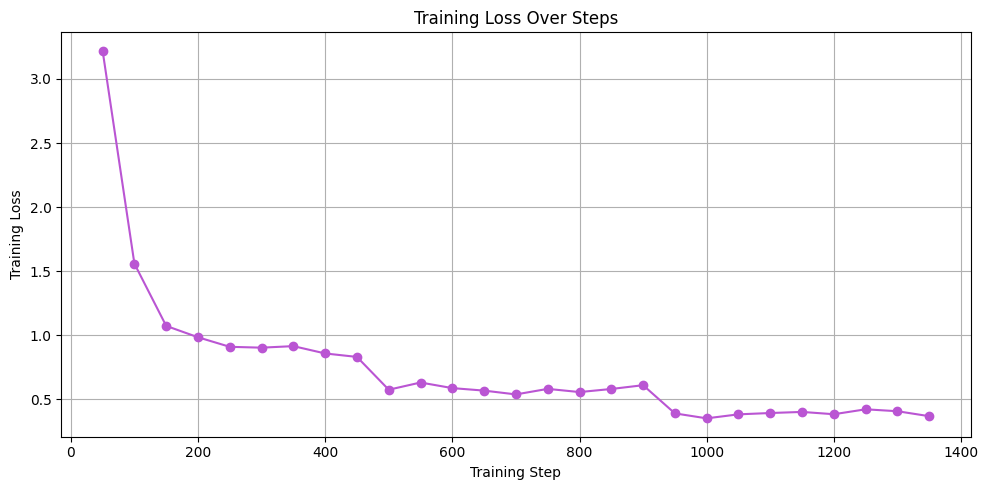

In [ ]:
import matplotlib.pyplot as plt

# Step and training loss data
steps = [
    50, 100, 150, 200, 250, 300, 350, 400, 450, 500,
    550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,
    1050, 1100, 1150, 1200, 1250, 1300, 1350
]

losses = [
    3.2205, 1.5589, 1.0731, 0.9845, 0.9099, 0.9033, 0.9153, 0.8581, 0.8311, 0.5751,
    0.6314, 0.5877, 0.5682, 0.5385, 0.5817, 0.5568, 0.5809, 0.6104, 0.3904, 0.3518,
    0.383, 0.3933, 0.4019, 0.3839, 0.4223, 0.4073, 0.3686
]

# Plotting
plt.figure(figsize=(10,5))
plt.plot(steps, losses, marker='o', linestyle='-', color='#BA55D3')
plt.title('Training Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()
